# Import Libraries and Data

In [1]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [2]:
train = pd.read_csv('data_format1/train_format1.csv')
test = pd.read_csv('data_format1/test_format1.csv')

In [3]:
train.shape

(260864, 3)

In [4]:
test.shape

(261477, 3)

In [5]:
train.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [6]:
test.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [7]:
user_final = pd.read_csv("user_final.csv", sep='\t')

In [8]:
user_final.drop(columns = {"Unnamed: 0"}, inplace=True)

In [9]:
user_final.head()

,user_id,age_range,gender,click,add,buy,save,userTotalAction,click_ratio_,add_ratio_,...,index,unique_item,unique_cat,unique_seller,unique_brand,unique_active_day,day_count,month_count,day_norm,rep_buyer
0,376517,6.0,1.0,73.0,0.0,5.0,1.0,79.0,0.924051,0.0,...,376517,39,17,20,20,10,10,3.333,0.592154,1.0
1,234512,5.0,0.0,47.0,0.0,7.0,2.0,56.0,0.839286,0.0,...,234512,29,18,21,20,11,11,3.667,0.651370,1.0
2,344532,5.0,0.0,64.0,0.0,8.0,19.0,91.0,0.703297,0.0,...,344532,54,25,20,21,14,14,2.800,0.829016,1.0
3,186135,5.0,0.0,193.0,0.0,2.0,5.0,200.0,0.965000,0.0,...,186135,21,11,11,10,5,5,5.000,0.296077,0.0
4,30230,5.0,0.0,29.0,0.0,3.0,0.0,32.0,0.906250,0.0,...,30230,24,13,14,14,13,13,2.167,0.769801,0.0


In [10]:
seller_final = pd.read_csv("seller_final.csv", sep='\t')

In [11]:
seller_final.drop(columns = {"Unnamed: 0"}, inplace=True)

In [12]:
seller_final.head()

,seller_id,click,cart,buy,fav,sellerTotalAction,click_to_buy_ratio,cart_to_buy_ratio,fav_to_buy_ratio,su_click,...,item_count,cat_count,brand_count,item_ratio,cat_ratio,brand_ratio,click_ratio,cart_ratio,buy_ratio,fav_ratio
0,1,308236.0,444.0,17705.0,12755.0,339140.0,-2.856965,3.683585,0.327902,29251.0,...,2977,44,2,0.002730,0.026538,0.000237,0.069011,0.008536,0.018073,0.021270
1,2,2030.0,8.0,189.0,144.0,2371.0,-2.369259,3.049799,0.270290,902.0,...,154,10,1,0.000141,0.006031,0.000118,0.002128,0.000193,0.000380,0.000544
2,3,2399.0,4.0,67.0,175.0,2645.0,-3.563716,2.610070,-0.950976,1103.0,...,171,4,1,0.000157,0.002413,0.000118,0.002602,0.000129,0.000153,0.000643
3,4,2646.0,2.0,294.0,164.0,3106.0,-2.194207,4.588363,0.581030,1384.0,...,155,7,2,0.000142,0.004222,0.000237,0.003265,0.000064,0.000474,0.000655
4,5,7483.0,9.0,144.0,556.0,8192.0,-3.943789,2.674149,-1.345831,3535.0,...,660,23,1,0.000605,0.013872,0.000118,0.008340,0.000290,0.000283,0.001962


# Merge train/test data with user/seller features

In [13]:
train =train.merge(user_final, how="left", on = ["user_id"])

In [14]:
train.rename(columns = {"merchant_id":"seller_id"}, inplace=True)

In [15]:
train = train.merge(seller_final, how="left", on = ["seller_id"])

In [16]:
train.shape

(260864, 52)

In [17]:
test.rename(columns = {"merchant_id":"seller_id"}, inplace=True)

In [18]:
test = test.merge(user_final, how="left", on = ["user_id"])

In [19]:
test = test.merge(seller_final, how="left", on = ["seller_id"])

In [20]:
test.shape

(261477, 52)

In [21]:
train.dropna(inplace=True)

In [22]:
response = train["label"]
train.drop(columns = {"label"}, inplace=True)

# Train/test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train, response,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [24]:
X_train.head()

,user_id,seller_id,age_range,gender,click_x,add,buy_x,save,userTotalAction,click_ratio_,...,item_count,cat_count,brand_count,item_ratio,cat_ratio,brand_ratio,click_ratio,cart_ratio,buy_ratio,fav_ratio
43751,315393,4385,2.0,1.0,16.0,0.0,1.0,0.0,17.0,0.941176,...,217,14,1,0.000199,0.008444,0.000118,0.008380,0.001160,0.001438,0.001568
214233,100343,3170,5.0,1.0,9.0,2.0,3.0,0.0,14.0,0.642857,...,253,22,2,0.000232,0.013269,0.000237,0.008279,0.000322,0.001424,0.002630
8460,104601,4394,5.0,0.0,30.0,0.0,2.0,0.0,32.0,0.937500,...,191,7,1,0.000175,0.004222,0.000118,0.026516,0.002770,0.005507,0.007330
107008,390331,4760,3.0,1.0,345.0,0.0,8.0,0.0,353.0,0.977337,...,724,18,1,0.000664,0.010856,0.000118,0.056273,0.005991,0.011950,0.014171
35997,67818,2836,2.0,0.0,9.0,0.0,4.0,6.0,19.0,0.473684,...,260,10,8,0.000238,0.006031,0.000948,0.002543,0.000129,0.000500,0.000750


In [25]:
# Removing Identifiers
train_identity = X_train[['user_id','seller_id']]
X_train = X_train.drop(columns = ['user_id','seller_id'])
test_identity = X_test[['user_id','seller_id']]
X_test = X_test.drop(columns = ['user_id','seller_id'])

# Normalization

In [26]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# Logistic Regression

In [27]:
# Fitting Model to the Training Set
classifier = LogisticRegression(random_state = 0, penalty = 'l1') 
#L1 regularization (Lasso) model, reduce correlation between features (screens)
#It penalizes any particular field that is strongly correlated to the responsed variable
classifier.fit(X_train, y_train)

/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
# Predicting Test Set
y_pred = classifier.predict(X_test)

In [29]:
# Evaluating Results
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.9377484089634488

Test Data Accuracy: 0.9377


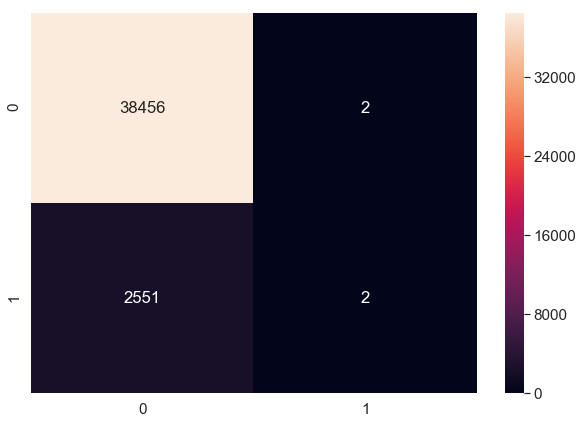

In [30]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

## Seriously Type II error, bad model performance

In [31]:
# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Logistic Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

Logistic Accuracy: 0.938 (+/- 0.000)


In [32]:
# Analyzing Coefficients
pd.concat([pd.DataFrame(train.drop(columns = 'user_id','seller_id').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,seller_id,0.057670
1,age_range,-0.044754
2,gender,-0.074567
3,click_x,0.034051
4,add,0.066628
5,buy_x,-0.038079
6,save,0.000000
7,userTotalAction,-0.094470
8,click_ratio_,-0.012479
9,add_ratio_,0.000000


In [33]:
## Grid Search (Round 1)
# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters

/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Took 2252.72 seconds


(0.9383823852137232, {'C': 0.01, 'penalty': 'l2'})

In [38]:
## Grid Search (Round 2)

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.1, 0.5, 0.9, 1, 2, 5]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters, grid_search.best_score_



/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Took 2749.70 seconds


(0.9383823852137232, {'C': 0.1, 'penalty': 'l1'}, 0.9383823852137232)

# Try fit logistic model according to grid search result

In [39]:
# Fitting Model to the Training Set
classifier = LogisticRegression(random_state = 0, penalty = 'l1', C = 0.1) 
#L1 regularization (Lasso) model, reduce correlation between features (screens)
#It penalizes any particular field that is strongly correlated to the responsed variable
classifier.fit(X_train, y_train)

/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
# Predicting Test Set
y_pred = classifier.predict(X_test)

In [41]:
# Evaluating Results
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.9377484089634488

In [42]:
# Fitting Model to the Training Set
classifier = LogisticRegression(random_state = 0, penalty = 'l2', C = 0.01) 
#L1 regularization (Lasso) model, reduce correlation between features (screens)
#It penalizes any particular field that is strongly correlated to the responsed variable
classifier.fit(X_train, y_train)

/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [43]:
# Predicting Test Set
y_pred = classifier.predict(X_test)
# Evaluating Results
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.9377484089634488

# Three model has exactly same accuracy: all has seriously type II error

In [44]:
# Formatting Final Results
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user_id', 'seller_id','label', 'predicted_reach']].reset_index(drop=True)

In [45]:
final_results.head(20)

,user_id,seller_id,label,predicted_reach
0,368639,2669,0,0
1,198781,2313,0,0
2,229716,2821,0,0
3,313274,1470,0,0
4,244065,2078,0,0
5,139974,798,0,0
6,98459,2772,0,0
7,34084,1738,1,0
8,253128,2915,0,0
9,418020,3954,0,0


# SVM

In [30]:
from sklearn import svm
# param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']} 
# rr=svm.SVC()
# gr=GridSearchCV(rr, param_grid=param_grid)
# rs=gr.fit(X_train, y_train)
# print(rs.best_estimator_)
# print(rs.score(X_test, y_test))
# correct=1.0*(clf.predict(X_test)==np.asarray(y_test)).sum()/len(y_test)
# print("Out of sample, we successfully predict", np.mean(correct)*100, "percent of the data")

In [32]:
# param_grid = {'kernel':['rbf'],
#              'C': 10**np.linspace(-5,5,50),
#              'gamma':10**np.linspace(-3,3,50),
#              'max_iter':[100]}
# rr=svm.SVC()
# gr=GridSearchCV(rr, param_grid=param_grid)
# rs=gr.fit(X_train, y_train)
# #print rs.score(X_test, Y_test)
# print (rs.best_params_)
# print (1.0*(rs.predict(X_test) == np.asarray(y_test)).sum()/len(y_test))

In [ ]:
#AUC

# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
OS=[]
for i in range(10):
    param_grid = {'n_estimators':range(1,51,5)}
    rf = RandomForestClassifier(n_jobs=-1,max_leaf_nodes=10)
    gs = GridSearchCV(rf,param_grid=param_grid,scoring='accuracy')
    rs = gs.fit(X_train,y_train)
    pred=rs.predict_proba(X_test)[:,1]
    OS.append(rs.score(X_test,y_test))
print("The average out sample: %f"%(np.mean(OS)))
print(rs.best_params_)

/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/envs/myEnv3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' ins

The average out sample: 0.937751
{'n_estimators': 6}


# Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
trained_model = gnb.fit(X_train,y_train)
y_pred_train = trained_model.predict_proba(X_train)[:,1]
y_pred_test = trained_model.predict_proba(X_test)[:,1]

# measure accuracy for the binary prediction task
print ('In sample prediction accuracy:',1.0*sum((y_pred_train>0.5)==y_train)/len(y_train))
print ('Out of sample prediction accuracy:',1.0*sum((y_pred_test>0.5)==y_test)/len(y_test))

In sample prediction accuracy: 0.8356111774889664
Out of sample prediction accuracy: 0.8319719099753725
